프로젝트: SentencePiece 사용하기
===

SentencePiece는 SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다.
- google/sentencepiece : https://github.com/google/sentencepiece    

네이버 영화리뷰 감정 분석 태스크에서 tokenizer를 SentencePiece로 바꾸어 적용해 봅니다. 
- 네이버 영화리뷰 감정 분석 태스크 : https://github.com/e9t/nsmc/

    
    
[목차]
1. SentencePiece 설치하기
2. Data 다운로드 및 분석
3. SentencePiece 모델 학습
4. Tokenizer 함수 작성
5. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

# 1. SentencePiece 설치하기

다음과 같이 설치를 진행합니다. SentencePiece는 python에서 쓰라고 만들어진 라이브러리는 아니지만 편리한 파이썬 wrapper를 아래와 같이 제공하고 있습니다.

In [1]:
!pip install sentencepiece

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# 2. Data 다운로드 및 분석 

In [2]:
# 라이브러리 import
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

In [3]:
path_to_file = os.getenv('HOME')+'/aiffel/GoingDeeper/nlp2/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

# 데이터 읽어보기 
print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


내려받은 데이터는 한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터입니다.
이번에 사용할 데이터는 한국어-영어 병렬을 이루는 말뭉치 중 한국어 부분으로, 전체 병렬 말뭉치는 후에 번역기를 만들며 사용할 예정입니다
     
문장은 위에서 확인한 것처럼 94123개가 포함되어 있습니다. 우리는 각 문장이 어느 정도의 길이를 가지는지 확인해보겠습니다! 이 과정을 거치면 지나치게 긴 데이터를 삭제하거나 (연산량을 감소시켜 학습 속도가 빨라집니다!) 지나치게 짧은 데이터를 검증 (무조건 필요가 없지는 않습니다, 단어 ↔ 단어 라면 번역을 학습할 수 있겠죠!) 할 수 있습니다. 즉, 데이터를 얼마나 사용할지 타협점을 정의할 수 있습니다.
     

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


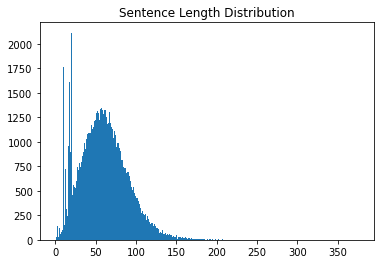

In [4]:
# 문장의 최단 길이, 최장 길이, 평균 길이 구하기 & 문장 길이 분포를 막대그래프로 표현
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

최단 길이 1, 최장 길이 377
    
1. 길이 1 짜리 문장은?
2. 앞에 치솟는 임의의 구간은 유의미한 데이터가 담겨있는 부분인가?
3. 어디서부터 어디까지 잘라서 쓰지?
    
하나하나 해결해 봅니다. 

## 길이가 1인 문장 

In [5]:
# 문장의 길이 별로 확인하는 함수
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

In [6]:
check_sentence_with_length(raw, 1)

’


- 문장의 길이가 1인 것은 노이즈 데이터인 것을 확인할 수 있습니다.

## 치솟는 임의의 구간

In [7]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이 추출
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [8]:
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

- 중복 데이터가 섞여 있는것을 확인할 수 있습니다. 

Python의 기본 자료형 set을 활용하여 중복을 제거한 후, 데이터 분포를 다시 확인해 봅니다.

In [9]:
cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거
print("Data Size:", len(cleaned_corpus))

Data Size: 77591


문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


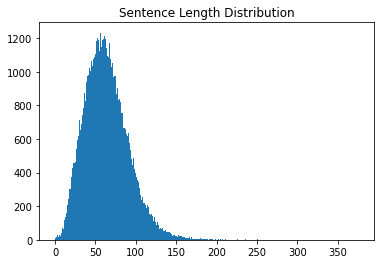

In [10]:
# 문장의 최단 길이, 최장 길이, 평균 길이 구하기 & 문장 길이 분포를 막대그래프로 표현
min_len = 999
max_len = 0
sum_len = 0

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus: # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

- 중복 데이터를 삭제하니 치솟는 구간이 사라졌습니다. 데이터의 개수도 17000개가량 줄어 77591 개가 되었습니다.

## 데이터 구간 설정 

후에 미니 배치를 만들 것을 생각하면 모든 데이터를 다 사용하는 것은 연산 측면에서 비효율적입니다. 미니 배치 특성상 각 데이터의 크기가 모두 동일해야 하기 때문에 가장 긴 데이터를 기준으로 Padding 처리를 해야 합니다.
   
길이별로 정렬하여 미니 배치를 구성해 Padding을 최소화하는 방법도 있지만 이는 데이터를 섞는 데 편향성이 생길 수 있으므로 지양해야 합니다. 여기서는 길이 150 이상의 데이터를 제거하고 사용하도록 합니다. 
    
그리고 앞서 확인한 것처럼 너무 짧은 데이터는 오히려 노이즈로 작용할 수 있습니다. 따라서 길이가 10 미만인 데이터도 제거하도록 합니다. 

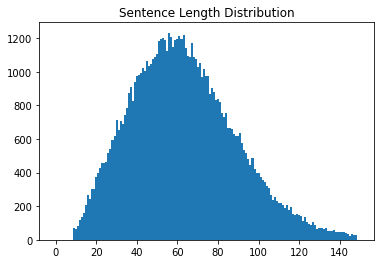

In [11]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려보기
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

- 최종적인 데이터 분포를 확인해 보았습니다.

# 3. SentencePiece 모델 학습

In [14]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/GoingDeeper/nlp2/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_unigram --vocab_size={}'.format(temp_file, vocab_size)    
)

- spm.SentencePieceTrainer.Train() :      
    https://github.com/google/sentencepiece/tree/master/python#model-training     
    parameter :    
    - --input: one-sentence-per-line raw corpus file    
    - --model_prefix: output model name prefix
    - --vocab_size: vocabulary size    
    - --model_type: model type. Choose from unigram (default), bpe, char, or word     
    https://github.com/google/sentencepiece#train-sentencepiece-model

In [16]:
!ls -l korean_spm_unigram*

-rw-r--r-- 1 root root 376904 Dec 18 07:04 korean_spm_unigram.model
-rw-r--r-- 1 root root 146388 Dec 18 07:04 korean_spm_unigram.vocab


- 정상적으로 SentencePiece 모델 학습이 완료된 후 korean_spm_unigram.model 파일과 korean_spm_unigram.vocab vocabulary 파일이 생성되었음을 확인할 수 있습니다.
      
그럼 이렇게 학습된 SentencePiece 모델을 어떻게 활용하는지 살펴보겠습니다.

In [17]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm_unigram.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1244, 11, 306, 7, 3599, 11, 286, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


# 4.  Tokenizer 함수 작성


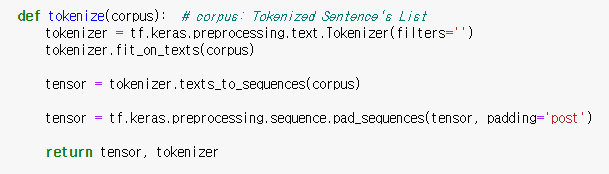
    
우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의할 겁니다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 그러니 아래 조건을 만족하는 함수를 정의하도록 하습니다.

1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

2. 생성된 vocab 파일을 읽어와 { \<word> : \<idx> } 형태를 가지는 word_index 사전과 { \<idx> : \<word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding 처리를 해줍니다. 

In [18]:
def sp_tokenize(s, corpus):
    # s : SentencePieceProcessor
    # corpus : sentence's List  # 1

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm_unigram.vocab", 'r') as f:
        vocab = f.readlines()
    
    # 2
    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})
    
    # 3
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

- f.readlines() : ead all the lines of a file in a list    
    https://docs.python.org/3/tutorial/inputoutput.html#methods-of-file-objects
- dict.update() : Update the dictionary with the key/value pairs, overwriting existing keys    
    https://docs.python.org/3/library/stdtypes.html#dict.update
- tf.keras.preprocessing.sequence.pad_sequences() : Pads sequences to the same length     
    https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In [19]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1949 5662    5    4 7975 1983    3    0    0    0    0    0    0    0]
 [ 107 1638  101    4    0  419   11    4   14    0 1969    3    3    3]]


- tensor 는 토큰화한 후 Encoding된 문장이고 패딩 처리가 된 것을 확인할 수 있습니다. 

# 5. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

 네이버 영화리뷰 감정 분석 태스크를 한 번쯤은 다루어 보았을 것입니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용했을 것입니다.
    
만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? 비교해 보는 것도 흥미로울 것입니다.
     
- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

## 5-1. 데이터 준비와 확인

In [21]:
# 모듈 임포트
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [22]:
# 데이터 읽어보기 
train_data = pd.read_table('~/aiffel/GoingDeeper/nlp2/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/GoingDeeper/nlp2/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [23]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


<AxesSubplot:>

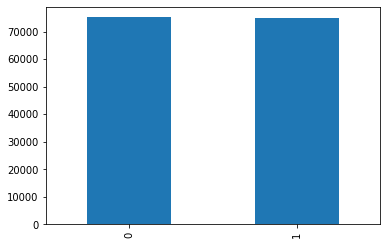

In [24]:
# train_data의 라벨 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [25]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  75173
1      1  74827


- 레이블이 비슷하지만 0인 리뷰가 근소하게 많은 것을 확인할 수 있습니다. 

In [26]:
# train_data의 NULL 개수 확인
print(train_data.isnull().sum())

id          0
document    5
label       0
dtype: int64


- NULL 데이터에 대한 처리가 필요합니다. 

## 5-2. 데이터로더 구성

nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. data_loader 안에서는 다음을 수행해야 합니다.
    
1. 데이터의 중복 제거
2. NaN 결측치 제거
3. SentencePiece 토크나이저로 토큰화
4. 불용어(Stopwords) 제거
5. 사전(word_to_index) 구성
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
7. X_train, y_train, X_test, y_test, word_to_index 리턴